> **Problem overview**

In 2018, air pollution in the Thai capital has come under increasing scrutiny with residents complaining of smog and respiratory problems. Some schools were closed or kept children indoors. The Pollution Control Department reported PM2.5 dust in the Bangkok Metropolitan at midday on Feb 8, 2018 and at midday it was measured at 72-95 micrograms per cubic metre, with the likelihood that it would increase.

In 2019, Bangkok is placed in the world’s top 10 cities with the worst air quality, Greenpeace Thailand was quoting the US air quality index measuring pollution floating around in the air we breathe. On Jan 30, 2019, the Pollution Control Department reported that levels of PM2.5 ranged from 59-142 micrograms per cubic metre of air during the past 24 hours, breaching the 50 micrograms per cubic metre.

In this challenge, the Bangkok air pollution dataset is refered to "berkeleyearth" and weather report dataset is referred to "wunderground" at weather station closed to Patumwan demonstration school.

Link:
* http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/Bangkok/Bangkok.txt
* https://www.wunderground.com/personal-weather-station/dashboard?ID=IBANGKOK26

In [1]:
# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import scientific computing library
import scipy

# import sklearn data preprocessing
from sklearn.preprocessing import RobustScaler

# import sklearn model class
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import xgboost model class
import xgboost as xgb

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring berkeleyearth and wunderground data
df_berkeleyearth = pd.read_csv('../input/berkeleyearth.csv')
df_wunderground = pd.read_csv('../input/wunderground.csv', parse_dates=['date'])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# visualize head of the berkeleyearth data
df_berkeleyearth.head(n=5)

,year,month,day,utc_hour,pm2.5,pm10_mask,retrospective
0,2016,3,3,8,62.9,1,0
1,2016,3,3,9,62.9,1,0
2,2016,3,3,10,55.5,1,0
3,2016,3,3,11,55.5,1,0
4,2016,3,3,12,47.9,1,0


In [4]:
# visualize tail of the wunderground data
df_wunderground.tail(n=5)

,date,time,temperature,dew_point,humidity,wind,speed,gust,pressure,precip_rate,precip_accum,uv,solar
274533,2019-01-31,11:35 PM,28.1 °C,25.2 °C,84%,West,0 kph,0 kph,1012.4 hPa,0 mm,0 mm,0,0 w/m²
274534,2019-01-31,11:40 PM,28.1 °C,25.1 °C,84%,West,0 kph,0 kph,1012.4 hPa,0 mm,0 mm,0,0 w/m²
274535,2019-01-31,11:45 PM,28.1 °C,25.2 °C,84%,East,0 kph,0 kph,1012.4 hPa,0 mm,0 mm,0,0 w/m²
274536,2019-01-31,11:50 PM,28.1 °C,25.2 °C,84%,WSW,0 kph,0 kph,1012.4 hPa,0 mm,0 mm,0,0 w/m²
274537,2019-01-31,11:55 PM,28.1 °C,25.1 °C,84%,East,0 kph,0 kph,1012.4 hPa,0 mm,0 mm,0,0 w/m²


> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [5]:
# countplot function plot - categorical variable (x-axis) vs. categorical variable (y-axis)
def countplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, v in enumerate(x): sns.countplot(x=v, hue=y, data=data, ax=axes[i])

In [6]:
# boxplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i])

In [7]:
# boxplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [8]:
# swarmplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def swarmplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.swarmplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.swarmplot(x=cat, y=v, data=data, ax=axes[i])

In [9]:
# violinplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i])

In [10]:
# violinplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [11]:
# scatterplot function plot - numerical variable (x-axis) vs. numerical variable (y-axis)
def scatterplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, xi in enumerate(x): sns.scatterplot(x=xi, y=y, data=data, ax=axes[i])

In [12]:
# feature extraction: date and datetime
df_berkeleyearth['date'] = pd.to_datetime(df_berkeleyearth[['year', 'month', 'day']])
df_berkeleyearth['datetime'] = pd.to_datetime(df_berkeleyearth['date'] + df_berkeleyearth['utc_hour'].astype('timedelta64[h]'))

In [13]:
# feature extraction: datetime
df_wunderground['datetime'] = pd.to_datetime(df_wunderground['date'].astype(str) + ' ' + df_wunderground['time'].astype(str).apply(lambda x: x[:x.find(':')] + ':00 ' + x[-2:]), format='%Y-%m-%d %I:%M %p')

In [14]:
# feature extraction: temperature
df_wunderground['temperature'] = df_wunderground['temperature'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' °C', '')).astype(float)

In [15]:
# feature extraction: dew_point
df_wunderground['dew_point'] = df_wunderground['dew_point'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' °C', '')).astype(float)

In [16]:
# feature extraction: humidity
df_wunderground['humidity'] = df_wunderground['humidity'].apply(lambda x: np.nan if x == '-- %' else x.replace('%', '')).astype(float)

In [17]:
# feature extraction: wind
df_wunderground['wind'] = df_wunderground['wind'].apply(lambda x: np.nan if x == '--' else x)
df_wunderground = pd.get_dummies(df_wunderground, columns=['wind'], drop_first=False)

In [18]:
# feature extraction: speed
df_wunderground['speed'] = df_wunderground['speed'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' kph', '')).astype(float)

In [19]:
# feature extraction: gust
df_wunderground['gust'] = df_wunderground['gust'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' kph', '')).astype(float)

In [20]:
# feature extraction: pressure
df_wunderground['pressure'] = df_wunderground['pressure'].apply(lambda x: x.replace(' hPa', '')).astype(float)

In [21]:
# feature extraction: precip_rate
df_wunderground['precip_rate'] = df_wunderground['precip_rate'].apply(lambda x: x.replace(' mm', '')).astype(float)

In [22]:
# feature extraction: precip_accum
df_wunderground['precip_accum'] = df_wunderground['precip_accum'].apply(lambda x: x.replace(' mm', '')).astype(float)

In [23]:
# feature extraction: uv
df_wunderground['uv'] = df_wunderground['uv'].apply(lambda x: np.nan if x == '--' else x).astype(float)

In [24]:
# feature extraction: solar
df_wunderground['solar'] = df_wunderground['solar'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' w/m²', '')).astype(float)

In [25]:
# feature extraction: fillna with ffill
col_fillnas = ['temperature', 'dew_point', 'humidity', 'speed', 'gust', 'pressure', 'precip_rate', 'precip_accum', 'uv', 'solar']
df_wunderground[col_fillnas] = df_wunderground[col_fillnas].fillna(method='ffill')

In [26]:
# feature extraction: fillna with 0
col_fillnas = ['wind_ENE', 'wind_ESE', 'wind_East', 'wind_NE', 'wind_NNE', 'wind_NNW', 'wind_NW', 'wind_North', 'wind_SE', 'wind_SSE', 'wind_SSW', 'wind_SW', 'wind_South', 'wind_WNW', 'wind_WSW', 'wind_West']
df_wunderground[col_fillnas] = df_wunderground[col_fillnas].fillna(0)

In [27]:
# feature extraction: wunderground_datetime dataframe
df_wunderground_datetime = df_wunderground.groupby(['datetime'], as_index=False).agg({
    'temperature': 'mean', 'dew_point': 'mean', 'humidity': 'mean', 'speed': 'mean', 'gust': 'mean',
    'pressure': 'mean', 'precip_rate': sum, 'precip_accum': sum, 'uv': 'mean', 'solar': 'mean',
    'wind_East': sum, 'wind_ENE': sum, 'wind_ESE': sum,
    'wind_North': sum, 'wind_NE': sum, 'wind_NNE': sum, 'wind_NNW': sum, 'wind_NW': sum,
    'wind_South': sum, 'wind_SE': sum, 'wind_SSE': sum, 'wind_SSW': sum, 'wind_SW': sum,
    'wind_West': sum, 'wind_WNW': sum, 'wind_WSW': sum
})

# feature extraction: data dataframe
df_data = pd.merge(df_berkeleyearth[['datetime', 'year', 'month', 'day', 'utc_hour', 'pm2.5', 'pm10_mask', 'retrospective']],
                   df_wunderground_datetime, how='left', left_on='datetime', right_on='datetime').rename(columns={'utc_hour': 'hour'})
df_data = df_data.set_index('datetime')

# feature extraction: combination of keyword date
df_data.insert(4, 'dayofweek', df_data.index.dayofweek)
df_data.insert(5, 'dayofyear', df_data.index.dayofyear)

In [28]:
# describe data dataframe
df_data.describe(include='all')

,year,month,day,hour,dayofweek,dayofyear,pm2.5,pm10_mask,retrospective,temperature,dew_point,humidity,speed,gust,pressure,precip_rate,precip_accum,uv,solar,wind_East,wind_ENE,wind_ESE,wind_North,wind_NE,wind_NNE,wind_NNW,wind_NW,wind_South,wind_SE,wind_SSE,wind_SSW,wind_SW,wind_West,wind_WNW,wind_WSW
count,23549.000000,23549.000000,23549.000000,23549.000000,23549.000000,23549.000000,23549.000000,23549.000000,23549.0,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.00000,21292.00000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000
mean,2017.105355,6.704064,15.762495,11.481846,2.959701,188.707546,25.427453,0.540108,0.0,29.278982,23.666708,72.874561,4.834166,8.500087,1007.461463,2.134459,18.813935,1.213563,170.032449,1.203081,0.680162,0.804152,0.275831,0.645219,0.46177,0.27137,0.560680,0.191762,0.202330,0.128029,0.709468,1.452564,1.304574,0.649070,1.720693
std,0.856971,3.380332,8.833734,6.924180,1.987804,103.385904,14.168323,0.498399,0.0,2.613928,2.525343,11.923719,3.151836,4.889376,3.023086,20.214869,69.629829,2.100654,237.927523,2.350903,1.429703,1.750505,0.877041,1.455200,1.25129,0.76414,1.511259,0.575763,0.595269,0.471388,1.448841,2.338033,2.419332,1.559459,2.670321
min,2016.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.500000,0.000000,0.0,17.163636,6.353846,27.583333,0.000000,0.000000,998.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,8.000000,5.000000,1.000000,104.000000,15.200000,0.000000,0.0,27.533333,22.990682,64.400000,2.488889,4.970000,1005.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,7.000000,16.000000,11.000000,3.000000,190.000000,21.500000,1.000000,0.0,29.141667,24.383333,73.583333,4.564881,8.345455,1007.270000,0.000000,0.000000,0.000000,7.909091,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2018.000000,10.000000,23.000000,17.000000,5.000000,277.000000,32.100000,1.000000,0.0,31.090909,25.250000,82.100000,6.825000,11.688352,1009.441667,0.000000,0.000000,1.744697,322.547980,2.000000,1.000000,1.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000
max,2019.000000,12.000000,31.000000,23.000000,6.000000,366.000000,115.400000,1.000000,0.0,37.741667,28.111111,97.636364,20.900000,33.775000,1020.916667,610.800000,1291.200000,10.383333,972.500000,24.000000,24.000000,24.000000,22.000000,24.000000,20.00000,14.00000,24.000000,12.000000,18.000000,12.000000,22.000000,24.000000,24.000000,26.000000,24.000000


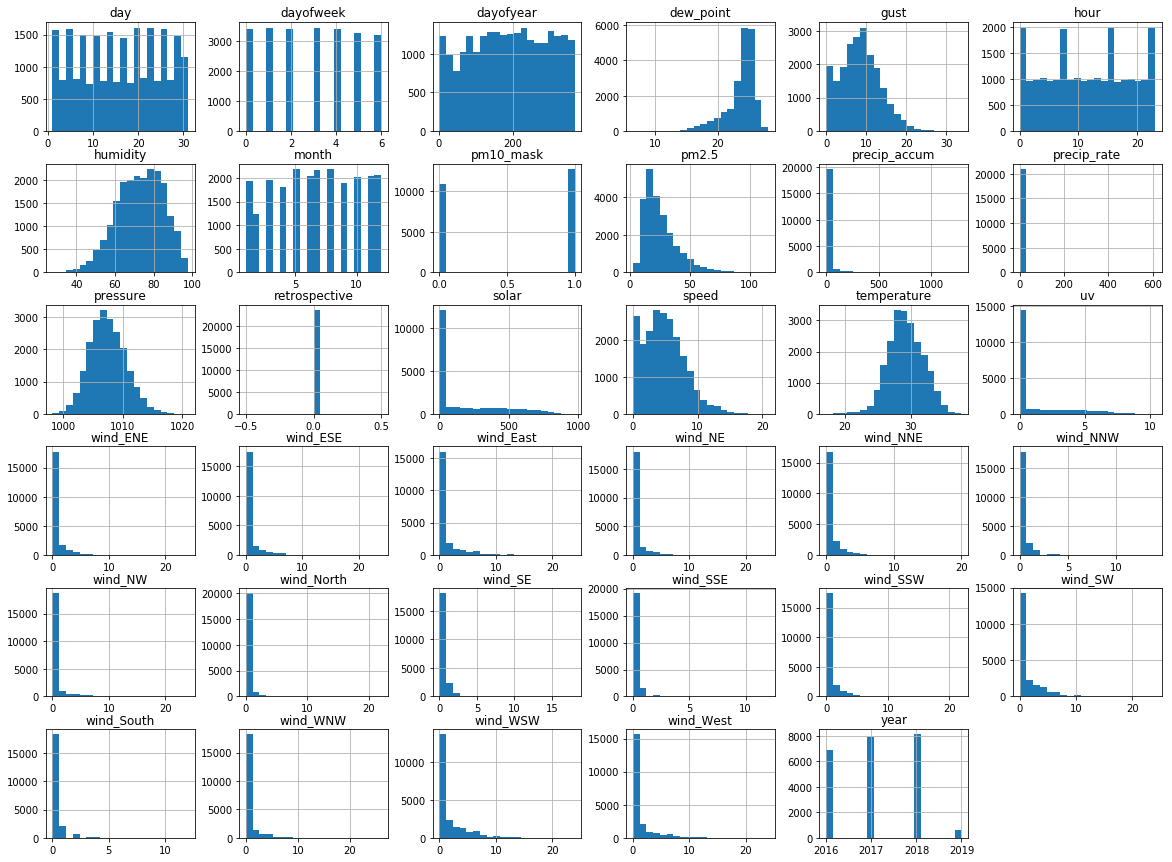

In [29]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(20, 15))

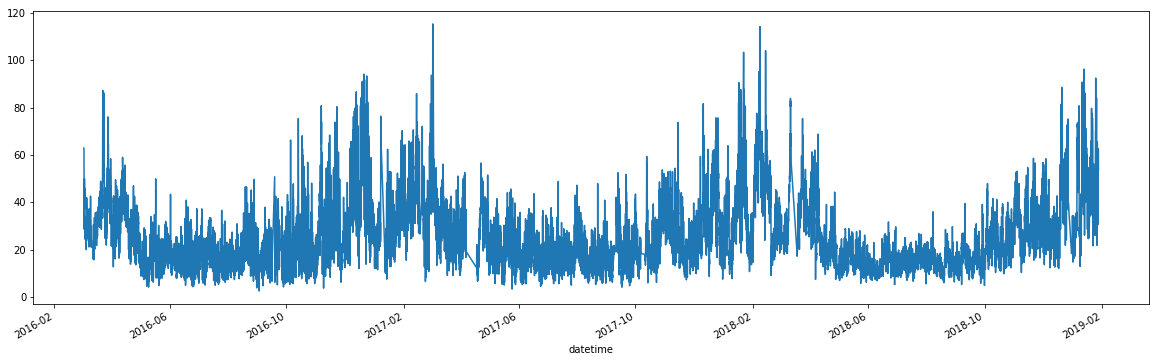

In [30]:
# feature exploration: season pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = df_data['pm2.5'].plot()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


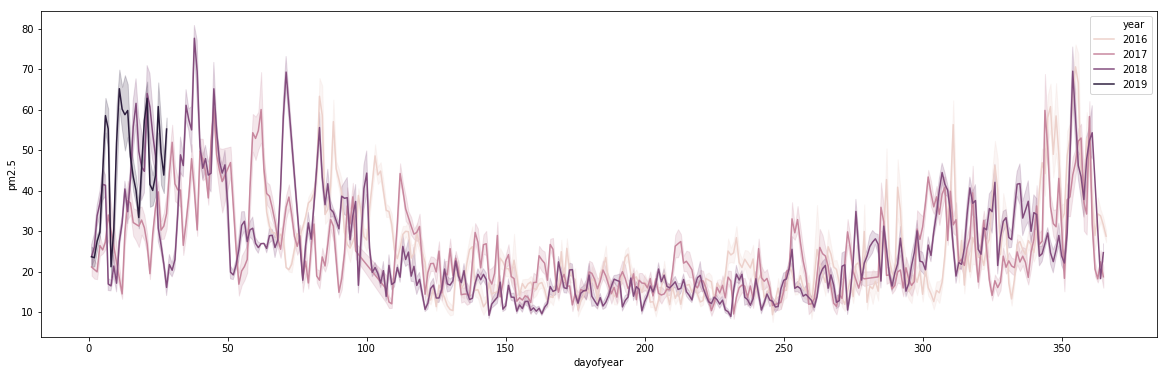

In [31]:
# feature exploration: season pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = sns.lineplot(x='dayofyear', y='pm2.5', data=df_data, hue='year')

The exploratory data analysis resulting in,

* **Year:** The PM2.5 tend to behave the similar trend between year.
* **Month:** The PM2.5 tend to correlate with the month/season in each year.

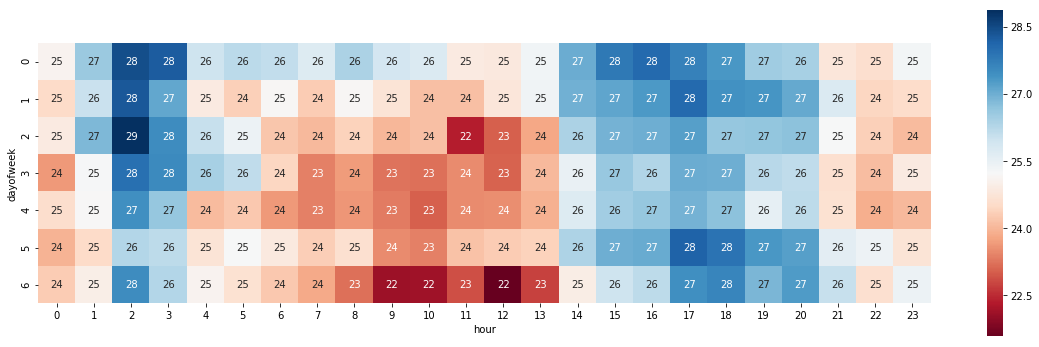

In [32]:
# feature exploration: dayofweek-hour pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
p = pd.pivot_table(df_data, values='pm2.5', index=['dayofweek'], columns=['hour'], aggfunc=np.mean)
_ = sns.heatmap(p, annot=True, cmap=plt.cm.RdBu, fmt='.0f', square=True)

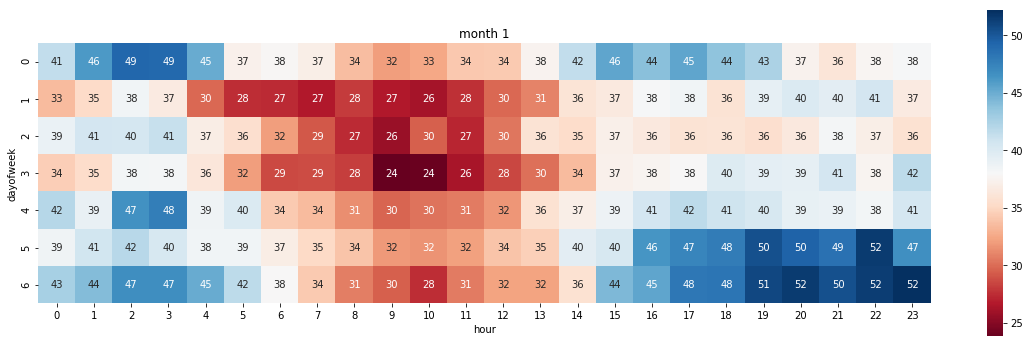

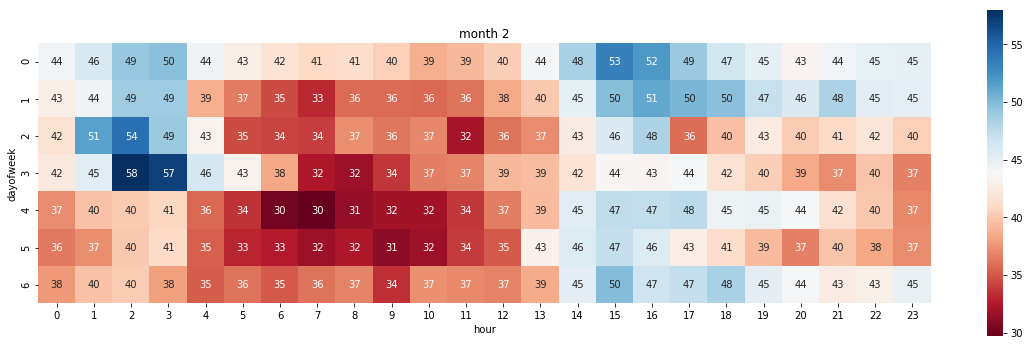

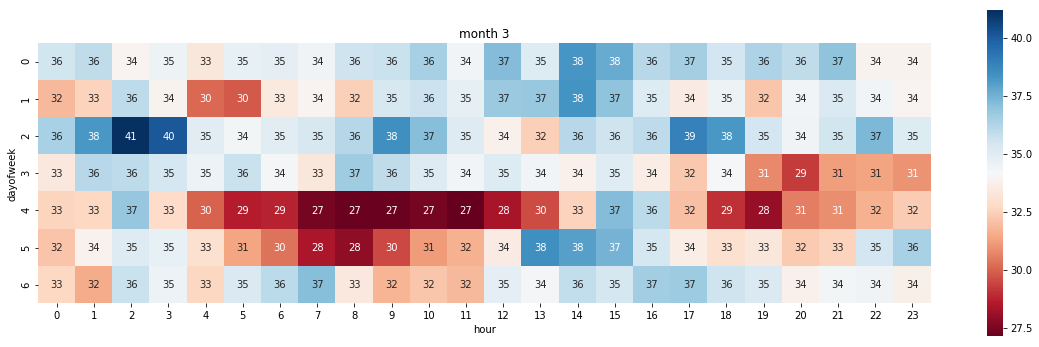

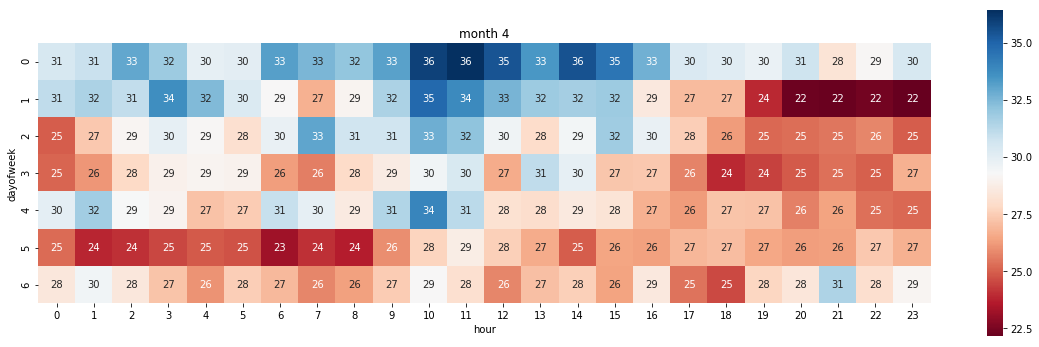

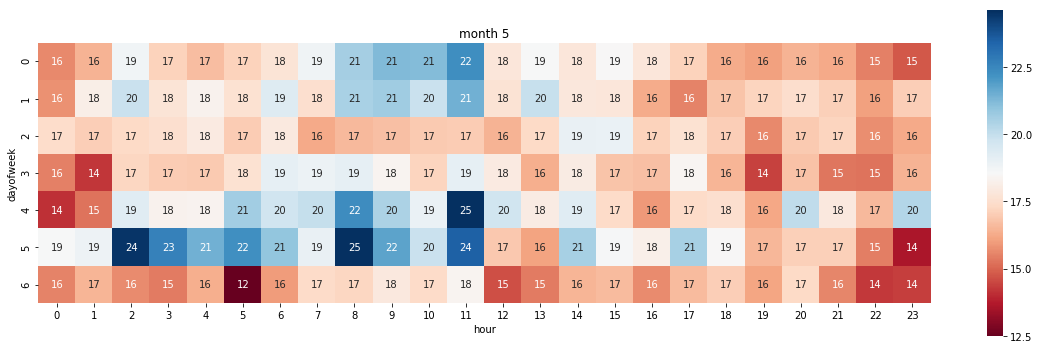

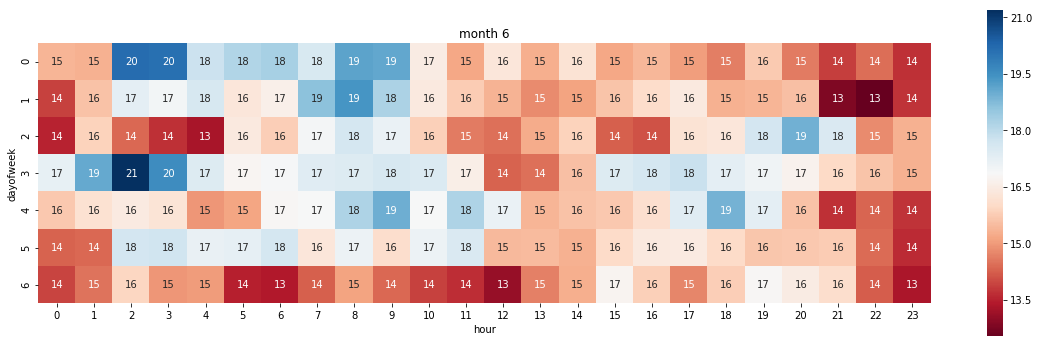

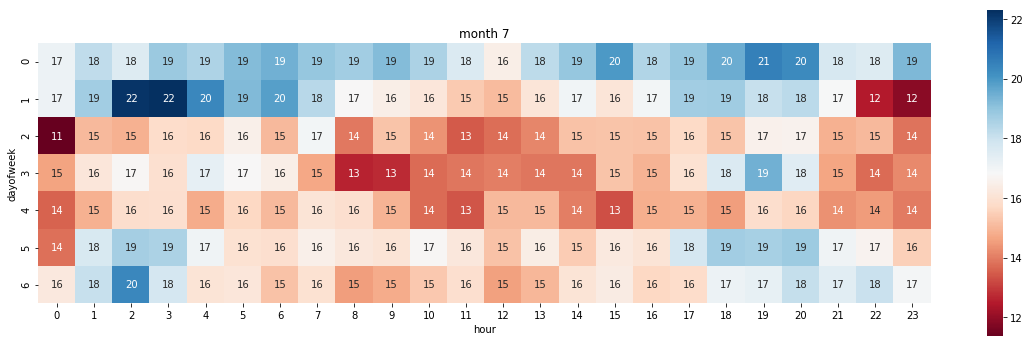

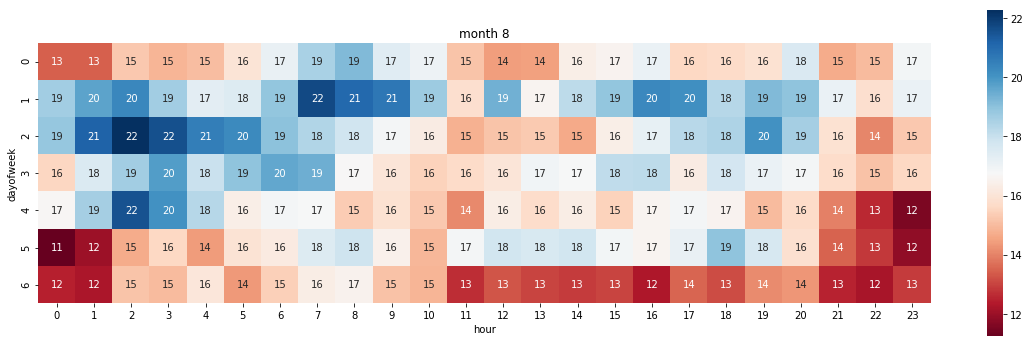

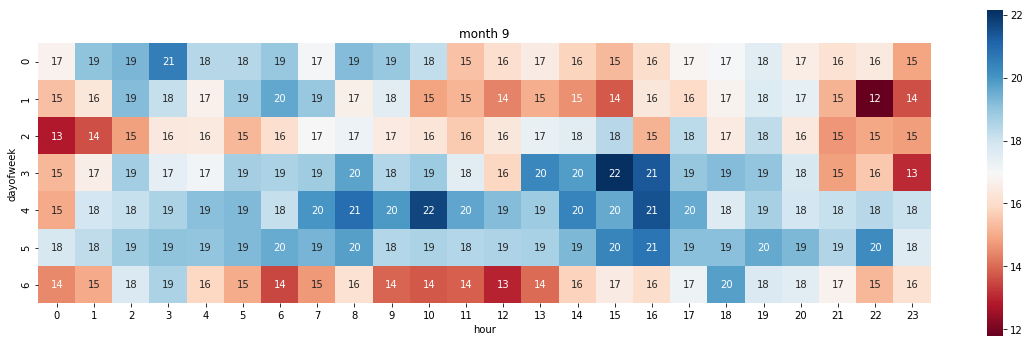

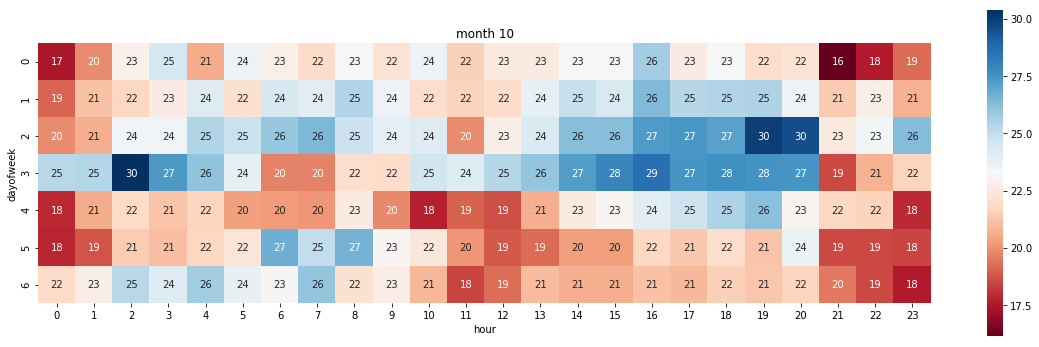

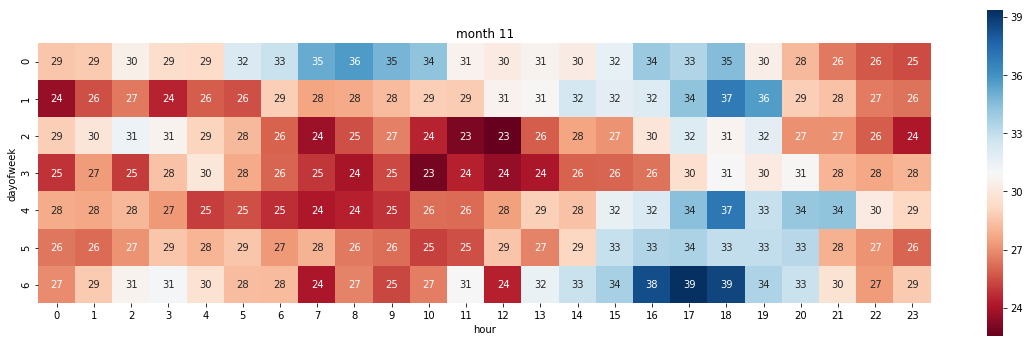

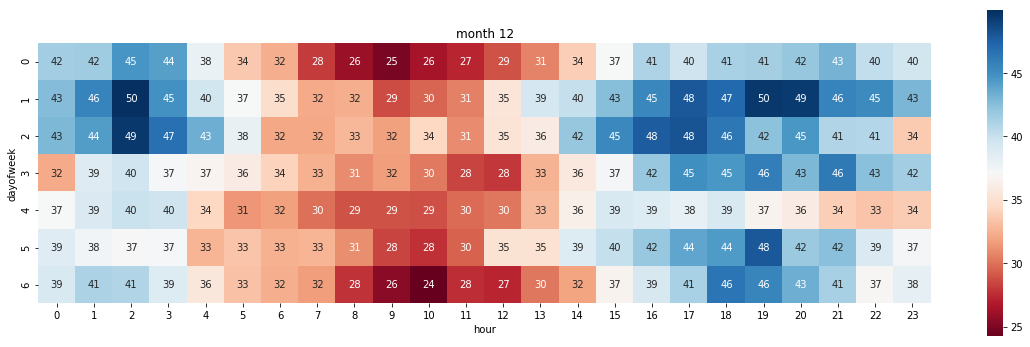

In [33]:
# feature exploration: month-dayofweek-hour pm2.5
for m in range(1, 13):
    fig, axes = plt.subplots(figsize=(20, 6))
    p = pd.pivot_table(df_data.loc[df_data['month'] == m], values='pm2.5', index=['dayofweek'], columns=['hour'], aggfunc=np.mean)
    _ = sns.heatmap(p, annot=True, cmap=plt.cm.RdBu, fmt='.0f', square=True)
    axes.set_title('month %d' %m)

The exploratory data analysis resulting in,

* **Hour:** During December to March in each year, the PM2.5 tend to be lower during the day-time and higher during the night time.
* **DayofWeek:** The PM2.5 tend to be higher during Sunday to Monday and lower during Tuesday to Friday.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


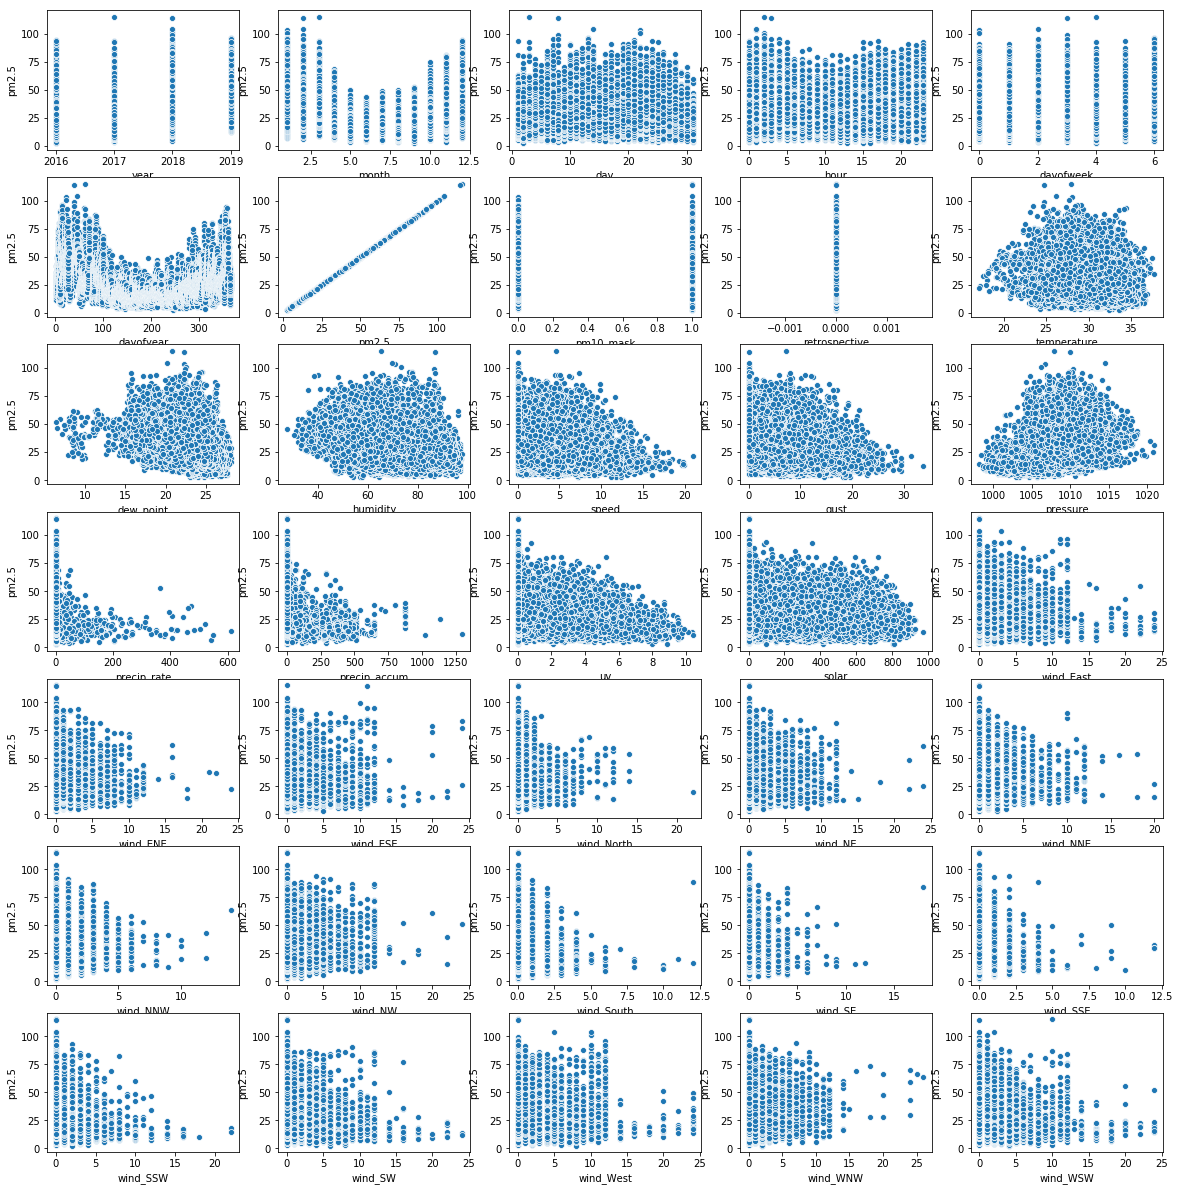

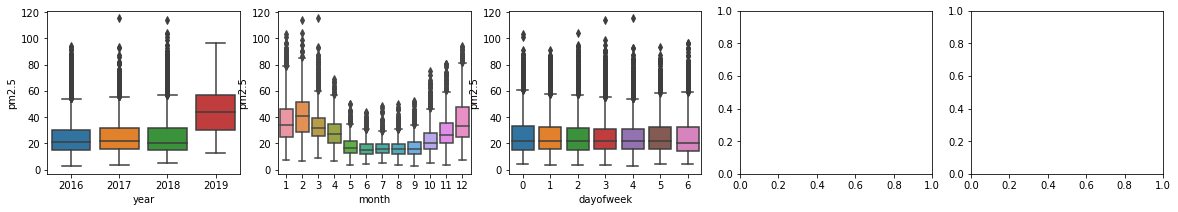

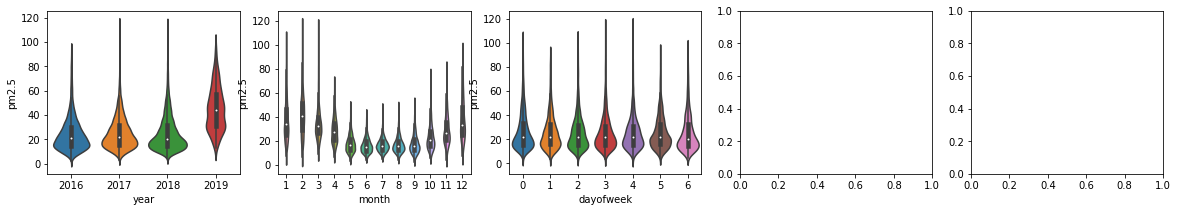

In [34]:
# feature exploration: pm2.5
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
col_object = ['year', 'month', 'dayofweek']
scatterplot(x=col_number, y='pm2.5', data=df_data, nrows=(len(col_number) - 1) // 5 + 1)
boxplot(cat=col_object, num='pm2.5', data=df_data, nrows=(len(col_object) - 1) // 5 + 1)
violinplot(cat=col_object, num='pm2.5', data=df_data, nrows=(len(col_object) - 1) // 5 + 1)

The exploratory data analysis resulting in,

* **Speed and gust:** The PM2.5 tend to be lower with higher wind speed and wind gust.
* **Precipitation rate and accumulation:** The PM2.5 tend to be lower with higher precipitation rate and accumulation.

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [35]:
# feature extraction: dropna
df_data = df_data.dropna()

In [36]:
# describe data dataframe
df_data.describe(include='all')

,year,month,day,hour,dayofweek,dayofyear,pm2.5,pm10_mask,retrospective,temperature,dew_point,humidity,speed,gust,pressure,precip_rate,precip_accum,uv,solar,wind_East,wind_ENE,wind_ESE,wind_North,wind_NE,wind_NNE,wind_NNW,wind_NW,wind_South,wind_SE,wind_SSE,wind_SSW,wind_SW,wind_West,wind_WNW,wind_WSW
count,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.0,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.00000,21292.00000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000,21292.000000
mean,2017.117086,6.639207,15.753522,11.490748,2.932087,186.744317,25.659459,0.535647,0.0,29.278982,23.666708,72.874561,4.834166,8.500087,1007.461463,2.134459,18.813935,1.213563,170.032449,1.203081,0.680162,0.804152,0.275831,0.645219,0.46177,0.27137,0.560680,0.191762,0.202330,0.128029,0.709468,1.452564,1.304574,0.649070,1.720693
std,0.885516,3.399105,8.851879,6.928804,1.988599,103.850709,14.416671,0.498739,0.0,2.613928,2.525343,11.923719,3.151836,4.889376,3.023086,20.214869,69.629829,2.100654,237.927523,2.350903,1.429703,1.750505,0.877041,1.455200,1.25129,0.76414,1.511259,0.575763,0.595269,0.471388,1.448841,2.338033,2.419332,1.559459,2.670321
min,2016.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.500000,0.000000,0.0,17.163636,6.353846,27.583333,0.000000,0.000000,998.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,8.000000,5.000000,1.000000,98.000000,15.200000,0.000000,0.0,27.533333,22.990682,64.400000,2.488889,4.970000,1005.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,7.000000,16.000000,12.000000,3.000000,188.000000,21.700000,1.000000,0.0,29.141667,24.383333,73.583333,4.564881,8.345455,1007.270000,0.000000,0.000000,0.000000,7.909091,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2018.000000,10.000000,23.000000,18.000000,5.000000,275.000000,32.525000,1.000000,0.0,31.090909,25.250000,82.100000,6.825000,11.688352,1009.441667,0.000000,0.000000,1.744697,322.547980,2.000000,1.000000,1.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000,2.000000
max,2019.000000,12.000000,31.000000,23.000000,6.000000,366.000000,115.400000,1.000000,0.0,37.741667,28.111111,97.636364,20.900000,33.775000,1020.916667,610.800000,1291.200000,10.383333,972.500000,24.000000,24.000000,24.000000,22.000000,24.000000,20.00000,14.00000,24.000000,12.000000,18.000000,12.000000,22.000000,24.000000,24.000000,26.000000,24.000000


In [37]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21292 entries, 2016-03-03 08:00:00 to 2019-01-28 02:00:00
Data columns (total 35 columns):
year             21292 non-null int64
month            21292 non-null int64
day              21292 non-null int64
hour             21292 non-null int64
dayofweek        21292 non-null int64
dayofyear        21292 non-null int64
pm2.5            21292 non-null float64
pm10_mask        21292 non-null int64
retrospective    21292 non-null int64
temperature      21292 non-null float64
dew_point        21292 non-null float64
humidity         21292 non-null float64
speed            21292 non-null float64
gust             21292 non-null float64
pressure         21292 non-null float64
precip_rate      21292 non-null float64
precip_accum     21292 non-null float64
uv               21292 non-null float64
solar            21292 non-null float64
wind_East        21292 non-null float64
wind_ENE         21292 non-null float64
wind_ESE         21292 non-null 

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

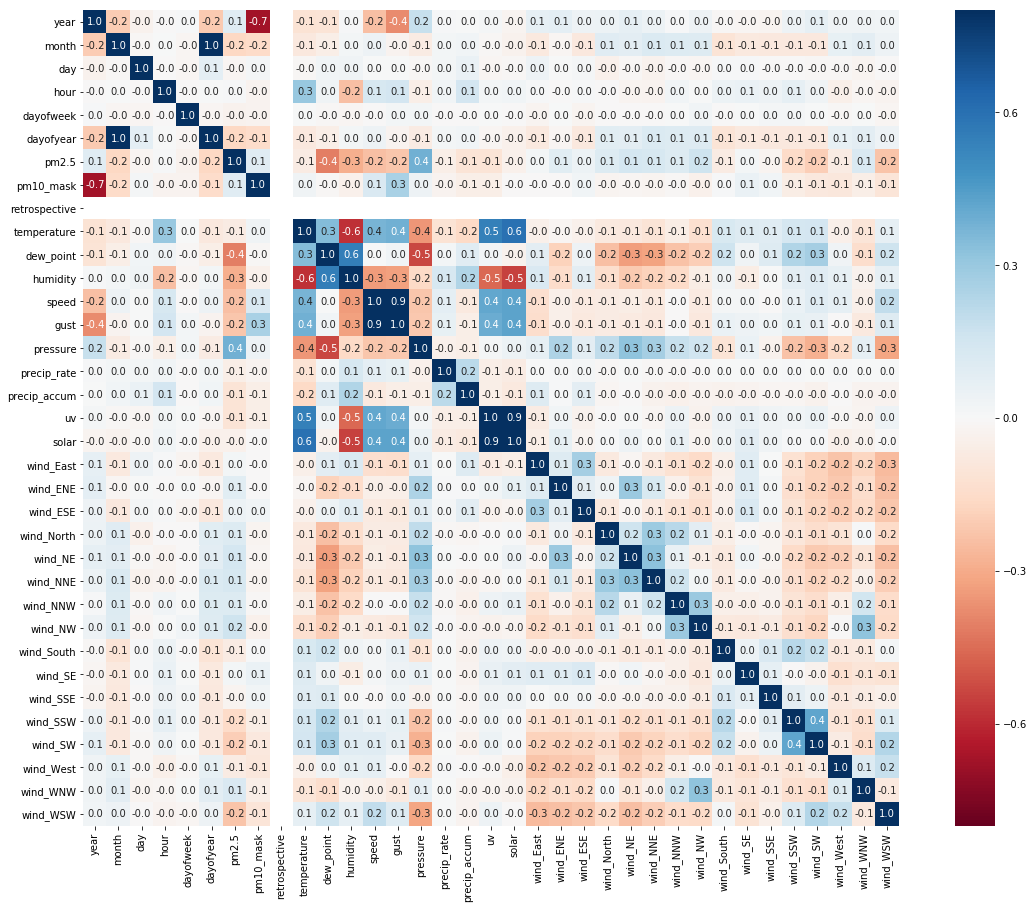

In [38]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_data.corr()
fig, axes = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [39]:
# select all features to evaluate the feature importances
x = df_data.drop(['pm2.5', 'pm10_mask', 'retrospective'], axis=1)
y = np.log1p(df_data['pm2.5'])

In [40]:
# set up lasso regression to find the feature importances
lassoreg = Lasso(alpha=1e-5).fit(x, y)
feat = pd.DataFrame(data=lassoreg.coef_, index=x.columns, columns=['FeatureImportances']).sort_values(['FeatureImportances'], ascending=False)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


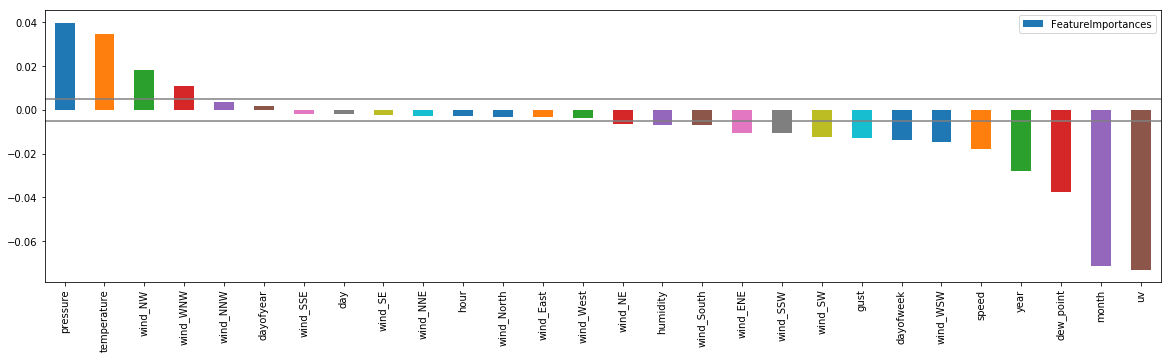

In [41]:
# plot the feature importances
feat[(feat['FeatureImportances'] < -1e-3) | (feat['FeatureImportances'] > 1e-3)].dropna().plot(y='FeatureImportances', figsize=(20, 5), kind='bar')
plt.axhline(-0.005, color="grey")
plt.axhline(0.005, color="grey")

In [42]:
# list feature importances
model_feat = feat[(feat['FeatureImportances'] < -0.005) | (feat['FeatureImportances'] > 0.005)].index

In [43]:
# set up random forest regression to find the feature importances
forestreg = RandomForestRegressor(n_estimators=100, random_state=58).fit(x, y)
feat = pd.DataFrame(data=forestreg.feature_importances_, index=x.columns, columns=['FeatureImportances']).sort_values(['FeatureImportances'], ascending=False)

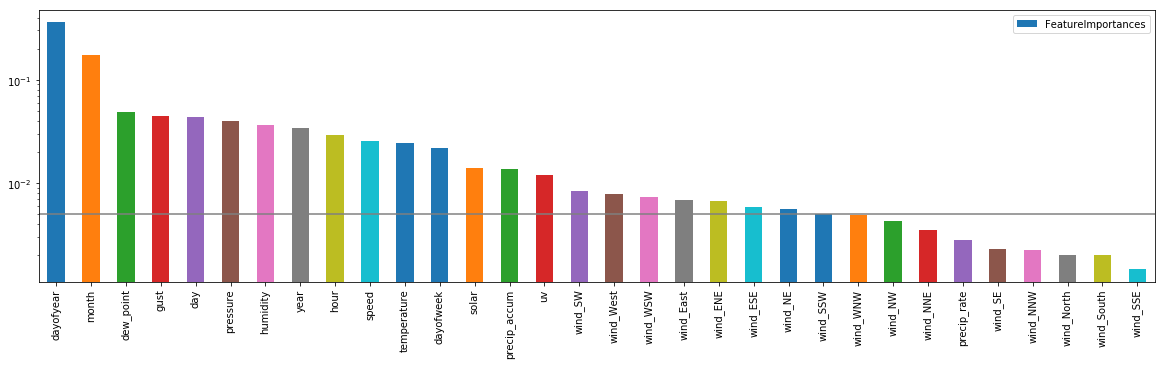

In [44]:
# plot the feature importances
feat.plot(y='FeatureImportances', figsize=(20, 5), kind='bar', logy=True)
plt.axhline(0.005, color="grey")

In [45]:
# list feature importances
model_feat = feat[feat['FeatureImportances'] > 0.005].index

In [46]:
# select the important features
x = df_data[model_feat]
y = np.log1p(df_data['pm2.5'])

In [47]:
# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

In [48]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.25)

In [49]:
# linear regression model setup
model_linreg = LinearRegression()

# linear regression model fit
model_linreg.fit(x_train, y_train)

# linear regression model prediction
model_linreg_ypredict = model_linreg.predict(x_validate)

# linear regression model metrics
model_linreg_rmse = mean_squared_error(y_validate, model_linreg_ypredict) ** 0.5
model_linreg_cvscores = np.sqrt(np.abs(cross_val_score(model_linreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('linear regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_linreg_rmse, model_linreg_cvscores.mean(), 2 * model_linreg_cvscores.std()))

linear regression
  root mean squared error: 0.4048, cross validation score: 0.4204 (+/- 0.0652)


In [50]:
# lasso regression model setup
model_lassoreg = Lasso(alpha=0.0001)

# lasso regression model fit
model_lassoreg.fit(x_train, y_train)

# lasso regression model prediction
model_lassoreg_ypredict = model_lassoreg.predict(x_validate)

# lasso regression model metrics
model_lassoreg_rmse = mean_squared_error(y_validate, model_lassoreg_ypredict) ** 0.5
model_lassoreg_cvscores = np.sqrt(np.abs(cross_val_score(model_lassoreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('lasso regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_lassoreg_rmse, model_lassoreg_cvscores.mean(), 2 * model_lassoreg_cvscores.std()))

lasso regression
  root mean squared error: 0.4060, cross validation score: 0.4211 (+/- 0.0601)


In [51]:
# ridge regression model setup
model_ridgereg = Ridge(alpha=10)

# ridge regression model fit
model_ridgereg.fit(x_train, y_train)

# ridge regression model prediction
model_ridgereg_ypredict = model_ridgereg.predict(x_validate)

# ridge regression model metrics
model_ridgereg_rmse = mean_squared_error(y_validate, model_ridgereg_ypredict) ** 0.5
model_ridgereg_cvscores = np.sqrt(np.abs(cross_val_score(model_ridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('ridge regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_ridgereg_rmse, model_ridgereg_cvscores.mean(), 2 * model_ridgereg_cvscores.std()))

ridge regression
  root mean squared error: 0.4059, cross validation score: 0.4210 (+/- 0.0600)


In [52]:
# elastic net regression model setup
model_elasticnetreg = ElasticNet(alpha=0.0001, l1_ratio=0.1)

# elastic net regression model fit
model_elasticnetreg.fit(x_train, y_train)

# elastic net regression model prediction
model_elasticnetreg_ypredict = model_elasticnetreg.predict(x_validate)

# elastic net regression model metrics
model_elasticnetreg_rmse = mean_squared_error(y_validate, model_elasticnetreg_ypredict) ** 0.5
model_elasticnetreg_cvscores = np.sqrt(np.abs(cross_val_score(model_elasticnetreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('elastic net regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_elasticnetreg_rmse, model_elasticnetreg_cvscores.mean(), 2 * model_elasticnetreg_cvscores.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

elastic net regression
  root mean squared error: 0.4059, cross validation score: 0.4211 (+/- 0.0601)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [53]:
# kernel ridge regression model setup
model_kernelridgereg = KernelRidge(alpha=0.1, degree=2, kernel='polynomial')

# kernel ridge regression model fit
model_kernelridgereg.fit(x_train, y_train)

# kernel ridge regression model prediction
model_kernelridgereg_ypredict = model_kernelridgereg.predict(x_validate)

# kernel ridge regression model metrics
model_kernelridgereg_rmse = mean_squared_error(y_validate, model_kernelridgereg_ypredict) ** 0.5
model_kernelridgereg_cvscores = np.sqrt(np.abs(cross_val_score(model_kernelridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('kernel ridge regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_kernelridgereg_rmse, model_kernelridgereg_cvscores.mean(), 2 * model_kernelridgereg_cvscores.std()))

kernel ridge regression
  root mean squared error: 0.3629, cross validation score: 0.4247 (+/- 0.0969)


In [54]:
# decision tree regression model setup
model_treereg = DecisionTreeRegressor(splitter='best', min_samples_split=2000)

# decision tree regression model fit
model_treereg.fit(x_train, y_train)

# decision tree regression model prediction
model_treereg_ypredict = model_treereg.predict(x_validate)

# decision tree regression model metrics
model_treereg_rmse = mean_squared_error(y_validate, model_treereg_ypredict) ** 0.5
model_treereg_cvscores = np.sqrt(np.abs(cross_val_score(model_treereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('decision tree regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_treereg_rmse, model_treereg_cvscores.mean(), 2 * model_treereg_cvscores.std()))

decision tree regression
  root mean squared error: 0.3600, cross validation score: 0.3950 (+/- 0.0844)


In [55]:
# random forest regression model setup
model_forestreg = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=58)

# random forest regression model fit
model_forestreg.fit(x_train, y_train)

# random forest regression model prediction
model_forestreg_ypredict = model_forestreg.predict(x_validate)

# random forest regression model metrics
model_forestreg_rmse = mean_squared_error(y_validate, model_forestreg_ypredict) ** 0.5
model_forestreg_cvscores = np.sqrt(np.abs(cross_val_score(model_forestreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestreg_rmse, model_forestreg_cvscores.mean(), 2 * model_forestreg_cvscores.std()))

random forest regression
  root mean squared error: 0.2851, cross validation score: 0.3969 (+/- 0.0831)


In [56]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(booster='gbtree', learning_rate=0.1, n_estimators=1000, objective='reg:linear', random_state=58,
                                colsample_bytree=0.9, max_depth=20, reg_alpha=0.1, reg_lambda=0.9, subsample=0.9)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, early_stopping_rounds=50, eval_set=[(x_validate, y_validate)], verbose=False,
                 callbacks=[xgb.callback.print_evaluation(period=50)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
model_xgbreg_cvscores = np.sqrt(np.abs(cross_val_score(model_xgbreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('xgboost regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_xgbreg_rmse, model_xgbreg_cvscores.mean(), 2 * model_xgbreg_cvscores.std()))

[0]	validation_0-rmse:2.43903
[50]	validation_0-rmse:0.230191
[100]	validation_0-rmse:0.224608
[150]	validation_0-rmse:0.223957
[200]	validation_0-rmse:0.223814
[250]	validation_0-rmse:0.223738
[300]	validation_0-rmse:0.223713
[350]	validation_0-rmse:0.223687
[400]	validation_0-rmse:0.223682
[450]	validation_0-rmse:0.22367
xgboost regression
  root mean squared error: 0.2237, cross validation score: 0.4122 (+/- 0.0869)


> **Supply or submit the results**

Our prediction is ready. Any suggestions to improve our score are welcome.

In [57]:
# model selection
final_model = model_xgbreg

# prepare testing data and compute the observed value
x_test = df_data[model_feat]
x_test = scaler.transform(x_test)
y_test = pd.DataFrame(np.expm1(final_model.predict(x_test)),
                      columns=['pm2.5'], index=df_data.index)

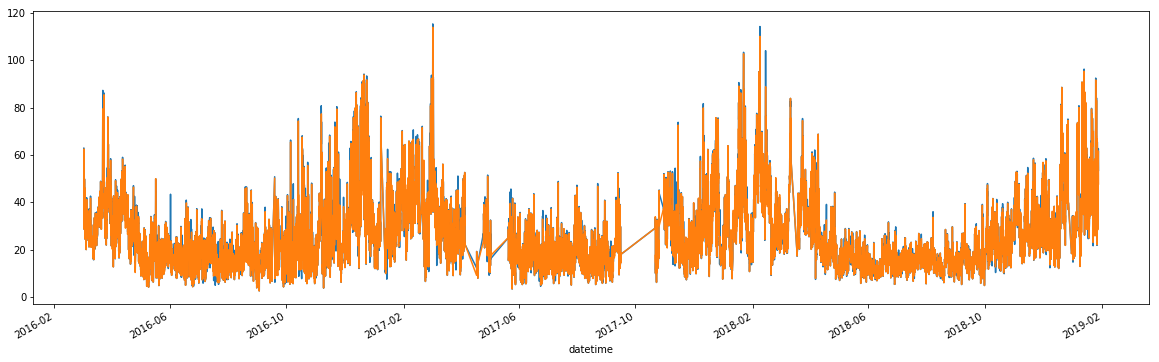

In [58]:
# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = df_data['pm2.5'].plot(ax=axes)
_ = y_test['pm2.5'].plot(ax=axes)

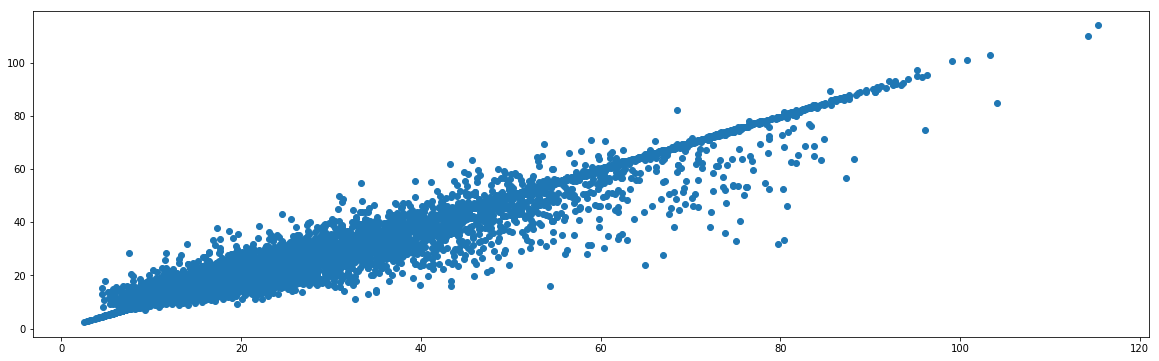

In [59]:
# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(df_data['pm2.5'], y_test['pm2.5'])